# 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!

## 라이브러리 버전을 확인해 봅니다.

In [1]:
import xgboost
import lightgbm
import missingno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


1.4.2
3.3.0
0.5.0
1.0


## 튜닝해볼 수 있는 모델 클래스 인자
- max_depth : 의사 결정 나무의 깊이, 정수 사용
- learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
- n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
- num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
- boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

## Step 1. 데이터 가져오기

In [2]:
# 필요한 라이브러리 import
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [7]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## Step 2. Train 데이터 전처리

### date 칼럼을 전처리

In [4]:
# int 형으로 전처리 하기
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### price 칼럼을 전처리

In [5]:
# y에 price를 저장 후 삭제
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### id 칼럼을 전처리

In [6]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


## Step 3. Test 데이터 전처리

Test 데이터에는 우리가 맞출 타겟 데이터인 price 칼럼은 없기 때문에 date, id 칼럼에 대해서만 전처리

In [7]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


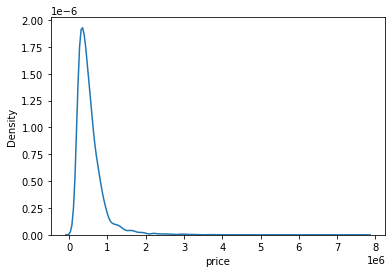

In [8]:
# seaborn의 kdeplot을 활용해 y의 분포 확인
sns.kdeplot(y)
plt.show()

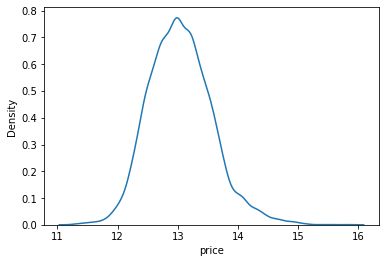

In [9]:
y = np.log1p(y) # log 변환을 통해 치우친 y의 분포를 개선
sns.kdeplot(y)
plt.show()

## Step 4. 학습 모델링

In [10]:
# 필요한 라이브러리
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [11]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다.  
random_state=1

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [12]:
# 4가지 모델에 대한 RMSE 값을 리턴하는 함수 get_scores
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [17]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,131579.080390
RandomForestRegressor,130081.013501
XGBRegressor,115479.923811
LGBMRegressor,111388.404203


## Step 5. 그리드 탐색

## 수정해 볼 수 있는 lightgbm 하이퍼 파라미터 인자
- max_depth : 의사 결정 나무의 깊이, 정수 사용
- learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
- n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
- num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
- boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

In [13]:
# 필요한 라이브러리
from sklearn.model_selection import GridSearchCV

In [21]:
# 하이퍼 파라미터
param_LGBMRegressor = {
    'learning_rate': [0.1],
    'n_estimators': [300],
}

param_XGBRegressor = {
    'learning_rate': [1,0.1,0.01,0.001],
    'n_estimators': [50, 100],
    'max_depth': [3,7,10],
}

prarm_GradientBoostingRegressor = {
    'n_estimators' : [100,200,300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [4, 8],
    'min_samples_leaf': [100,150],
    'max_features': [0.3, 0.1],
}

param_RandomForestRegressor = {
     'n_estimators' : [1,10, 100],
     'max_depth' : [6, 8, 10, 12],
     'min_samples_leaf' : [8, 12, 18],
     'min_samples_split' : [8, 16, 20],
}

## GridSearchCV의 인자
- param_grid: 하이퍼파라미터의 이름의 문자열을 key로 갖고, 시도하고자 하는 하이퍼파라미터의 값들의 list를 대응되는 value로 갖는 dictionary를 전달한다.

- scoring: 각 모델을 평가하는 기준인 하나의 또는 여러 개의 scoring 방법을 지정한다.

- n_jobs: 병렬적으로(in parallel) 수행되는 작업의 개수를 지정한다. -1은 가능한 모든 processor을 사용하도록 지정한다.

- refit: 최적의 하이퍼파라미터 조합을 확인한 후, 전체 데이터셋에 대하여 이 조합의 모델을 훈련시킬지 여부를 결정한다. 두 개 이상의 scoring 방법을 지정한 경우, 이는 최적의 모델을 선택할 시 가장 우선적으로 고려할 metric을 의미하는 문자열로 지정되어야 한다. 또한 best_estimator_를 사용자가 직접 선택해야 하는 상황인 경우 refit 매개변수가 best_index_를 반환하는 함수로 지정될 수 있다. 이때 best_estimator_와 best_params_는 best_index_를 바탕으로 선택된다. 

- cv: 교차검증의 구체적인 방법론을 결정한다. int 값을 입력하는 경우, 이는 k-fold 교차검증방법의 폴드 수를 의미하게 된다. 또는 CV splitter을 사용해 (train, test) split의 index array를 생성하여 이것으로 지정할 수 있다. estimator가 분류 모델로 지정된 경우, StratifiedKFold가 사용된다. 

- verbose: 메시지의 세부성을 결정한다. 1보다 큰 경우, 각 폴드와 각 하이퍼파라미터의 조합에 대한 계산 시간이 보여진다. 2보다 큰 경우, score이 함께 보여진다. 3보다 큰 경우 각 폴드와 하이퍼파라미터 조합의 index도 함께 보여진다.

- pre_dispatch: 병렬적으로 작업이 이루어질 때 전송되는 작업의 수를 결정한다. 이 값을 줄여 CPU가 감당할 수 있는 양 이상의 계산량이 할당되는 것을 막을 수 있다. 

- return_train_score: cv_results_ attribute가 training scores을 포함할지 결정한다. training scores는 일반적으로 서로 다른 파라미터의 값이 과적합에 어떻게 영향을 끼치는지 알아보고자 할 때 활용된다. 하지만 계산자체가 매우 expensive하기 때문에 최적의 모델을 선택할 때 주로 고려되지는 않는다.

In [15]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

## LGBMRegressor

In [16]:
model = LGBMRegressor(random_state=random_state)

In [22]:
result_LGBMRegressor = my_GridSearch(model, train, y, param_LGBMRegressor, verbose=2, n_jobs=5)
result_LGBMRegressor

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,learning_rate,n_estimators,score,RMSLE
0,0.1,300,-0.026091,0.161527


In [33]:
# LGBMRegressor의 최적값
model_lgb = LGBMRegressor(learning_rate = 0.1, n_estimators = 300, random_state=random_state)
model_lgb.fit(train, y)
pred_lgb = model_lgb.predict(test)
pred_lgb

array([13.12160458, 13.10226918, 14.15043868, ..., 13.05037436,
       12.67158278, 13.01735592])

In [34]:
pred_lgb = np.expm1(pred_lgb)
pred_lgb

array([ 499619.74521686,  490052.17258291, 1397838.90879818, ...,
        465269.55869982,  318564.30877008,  450157.90324192])

## GradientBoostingRegressor

In [40]:
model = GradientBoostingRegressor(random_state=random_state)

In [43]:
result_GradientBoostingRegressor = my_GridSearch(model, train, y, prarm_GradientBoostingRegressor, verbose=2, n_jobs=5)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END learning_rate=0.1, max_depth=4, max_features=0.3, min_samples_leaf=100, n_estimators=100; total time=   6.5s
[CV] END learning_rate=0.1, max_depth=4, max_features=0.3, min_samples_leaf=100, n_estimators=200; total time=  13.3s
[CV] END learning_rate=0.1, max_depth=4, max_features=0.3, min_samples_leaf=100, n_estimators=300; total time=  17.9s
[CV] END learning_rate=0.1, max_depth=4, max_features=0.3, min_samples_leaf=150, n_estimators=200; total time=  11.2s
[CV] END learning_rate=0.1, max_depth=4, max_features=0.3, min_samples_leaf=150, n_estimators=300; total time=  16.5s
[CV] END learning_rate=0.1, max_depth=4, max_features=0.1, min_samples_leaf=100, n_estimators=100; total time=   1.3s
[CV] END learning_rate=0.1, max_depth=4, max_features=0.1, min_samples_leaf=100, n_estimators=100; total time=   2.0s
[CV] END learning_rate=0.1, max_depth=4, max_features=0.1, min_samples_leaf=100, n_estimators=100; total time=  

In [44]:
result_GradientBoostingRegressor

,learning_rate,max_depth,max_features,min_samples_leaf,n_estimators,score,RMSLE
14,0.10,8,0.3,100,300,-0.027021,0.164381
17,0.10,8,0.3,150,300,-0.027139,0.164739
38,0.05,8,0.3,100,300,-0.027261,0.165109
13,0.10,8,0.3,100,200,-0.027308,0.165252
16,0.10,8,0.3,150,200,-0.027594,0.166113
...,...,...,...,...,...,...,...
58,0.01,4,0.1,150,200,-0.105945,0.325492
66,0.01,8,0.1,100,100,-0.133889,0.365909
69,0.01,8,0.1,150,100,-0.137916,0.371370
54,0.01,4,0.1,100,100,-0.157460,0.396812


[CV] END learning_rate=0.01, max_depth=8, max_features=0.1, min_samples_leaf=150, n_estimators=200; total time=   4.8s
[CV] END learning_rate=0.01, max_depth=8, max_features=0.1, min_samples_leaf=150, n_estimators=300; total time=   7.0s
[CV] END learning_rate=0.01, max_depth=8, max_features=0.1, min_samples_leaf=150, n_estimators=300; total time=   7.1s
[CV] END learning_rate=0.01, max_depth=8, max_features=0.1, min_samples_leaf=100, n_estimators=100; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=8, max_features=0.1, min_samples_leaf=100, n_estimators=200; total time=   5.1s
[CV] END learning_rate=0.01, max_depth=8, max_features=0.1, min_samples_leaf=100, n_estimators=300; total time=   7.1s
[CV] END learning_rate=0.01, max_depth=8, max_features=0.1, min_samples_leaf=150, n_estimators=100; total time=   2.5s
[CV] END learning_rate=0.01, max_depth=8, max_features=0.1, min_samples_leaf=150, n_estimators=200; total time=   4.9s
[CV] END learning_rate=0.01, max_depth=8, max_fe

In [25]:
# GradientBoostingRegressor의 최적값
model_gb = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 8, max_features = 0.3, min_samples_leaf = 100, n_estimators = 300, random_state=random_state)
model_gb.fit(train, y)
pred_gb = model_gb.predict(test)
pred_gb

array([13.18294188, 12.96928911, 14.1862819 , ..., 13.06645932,
       12.61452467, 12.98740196])

In [26]:
pred_gb = np.expm1(pred_gb)
pred_gb

array([ 531224.49841973,  429031.99654514, 1448850.74772535, ...,
        472813.93002972,  300896.41374372,  436873.80932042])

## RandomForestRegressor

In [49]:
model = RandomForestRegressor(random_state=random_state)

In [50]:
result_RandomForestRegressor = my_GridSearch(model, train, y, param_RandomForestRegressor, verbose=2, n_jobs=5)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=8, n_estimators=1; total time=   0.3s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=8, n_estimators=10; total time=   2.5s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=8, n_estimators=100; total time=  19.5s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=16, n_estimators=1; total time=   0.3s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=16, n_estimators=1; total time=   0.3s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=16, n_estimators=10; total time=   2.8s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=16, n_estimators=100; total time=  19.8s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=20, n_estimators=1; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=8, min_samples_split=20, n_estimators=1; total time=   0.2s
[CV] END max_depth=6, min_samples_leaf=8, m

In [51]:
result_RandomForestRegressor

,max_depth,min_samples_leaf,min_samples_split,n_estimators,score,RMSLE
83,12,8,8,100,-0.034668,0.186195
86,12,8,16,100,-0.034668,0.186195
89,12,8,20,100,-0.034809,0.186572
98,12,12,20,100,-0.035865,0.189380
95,12,12,16,100,-0.035865,0.189380
...,...,...,...,...,...,...
0,6,8,8,1,-0.061797,0.248589
18,6,18,8,1,-0.061844,0.248685
21,6,18,16,1,-0.061844,0.248685
24,6,18,20,1,-0.061844,0.248685


In [52]:
# RandomForestRegressor의 최적값
model = RandomForestRegressor(max_depth = 12, min_samples_leaf = 8, min_samples_split = 8, n_estimators = 100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[CV] END max_depth=10, min_samples_leaf=18, min_samples_split=20, n_estimators=100; total time=  28.7s
[CV] END max_depth=12, min_samples_leaf=8, min_samples_split=8, n_estimators=1; total time=   0.5s
[CV] END max_depth=12, min_samples_leaf=8, min_samples_split=8, n_estimators=10; total time=   4.1s
[CV] END max_depth=12, min_samples_leaf=8, min_samples_split=8, n_estimators=100; total time=  35.6s
[CV] END max_depth=12, min_samples_leaf=8, min_samples_split=16, n_estimators=10; total time=   3.6s
[CV] END max_depth=12, min_samples_leaf=8, min_samples_split=16, n_estimators=100; total time=  33.4s
[CV] END max_depth=12, min_samples_leaf=8, min_samples_split=20, n_estimators=1; total time=   0.4s
[CV] END max_depth=12, min_samples_leaf=8, min_samples_split=20, n_estimators=10; total time=   3.4s
[CV] END max_depth=12, min_samples_leaf=8, min_samples_split=20, n_estimators=100; total time=  34.6s
[CV] END max_depth=12, min_samples_leaf=12, min_samples_split=8, n_estimators=10; total tim

array([13.05912483, 13.12516225, 14.11936435, ..., 13.01268101,
       12.71031338, 12.98381526])

In [53]:
prediction = np.expm1(prediction)
prediction

array([ 469358.75901806,  501400.39514141, 1355069.91397243, ...,
        448058.36405461,  331144.58259201,  435309.67888956])

## XGBRegressor

In [21]:
model = XGBRegressor(random_state=random_state)

In [22]:
result_XGBRegressor = my_GridSearch(model, train, y, param_XGBRegressor, verbose=2, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

[CV] END ......learning_rate=1, max_depth=3, n_estimators=50; total time=  11.6s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=100; total time=  17.8s
[CV] END ......learning_rate=1, max_depth=7, n_estimators=50; total time=  47.5s
[CV] END .....learning_rate=1, max_depth=7, n_estimators=100; total time=  58.2s
[CV] END .....learning_rate=1, max_depth=10, n_estimators=50; total time= 1.2min
[CV] END ....learning_rate=1, max_depth=10, n_estimators=100; total time= 2.2min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  24.5s
[CV] END ....learning_rate=0.1, max_depth=7, n_estimators=50; total time=  44.9s
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time= 1.3min
[CV] END ...learning_rate=0.1, max_depth=10, n_estimators=50; total time=  49.5s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=100; total time= 1.8min
[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time=  12.8s
[CV] END ...learning_rate=0.

In [23]:
result_XGBRegressor

,learning_rate,max_depth,n_estimators,score,RMSLE
11,0.100,10,100,-0.027051,0.164472
9,0.100,7,100,-0.027358,0.165402
7,0.100,3,100,-0.033703,0.183584
10,0.100,10,50,-0.034190,0.184906
8,0.100,7,50,-0.035210,0.187644
1,1.000,3,100,-0.036233,0.190349
0,1.000,3,50,-0.036848,0.191959
6,0.100,3,50,-0.045013,0.212162
2,1.000,7,50,-0.054577,0.233618
3,1.000,7,100,-0.056464,0.237622


In [27]:
# XGBRegressor의 최적값
model_xgb = XGBRegressor(learning_rate = 0.1, max_depth = 10, n_estimators = 100, random_state=random_state)
model_xgb.fit(train, y)
pred_xgb = model_xgb.predict(test)
pred_xgb

array([13.161026, 12.928667, 14.040682, ..., 13.058372, 12.731839,
       13.017363], dtype=float32)

In [28]:
pred_xgb = np.expm1(pred_xgb)
pred_xgb

array([ 519708.88,  411953.03, 1252536.2 , ...,  469005.3 ,  338350.03,
        450160.9 ], dtype=float32)

In [37]:
pred = (pred_gb + pred_xgb + pred_lgb) / 3
pred

array([ 516851.03954553,  443679.06679268, 1366408.63550785, ...,
        469029.60040985,  319270.2512546 ,  445730.87293745])

In [38]:
def save_submission():
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = pred
    submission_csv_path = 'submission.csv'
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [39]:
save_submission()

submission.csv saved!
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   1.5s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   1.9s
[CV] END ................learning_rate=0.1, n_estimators=300; total time=   4.3s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   1.4s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   1.7s
[CV] END ................learning_rate=0.1, n_estimators=300; total time=   4.5s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   2.4s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   2.2s
[CV] END ................learning_rate=0.1, n_estimators=300; total time=   4.5s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   1.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   2.2s
[CV] END ................learning_rate=0.1, n_estimators=300; total time=   4.5s
[CV] E

## 프로젝트 결과 및 회고
- 이 프로젝트는 House Price Prediction으로 보스턴의 주택 가격이 담긴 data를 불러와 여러 모델로 학습시켜 주택 가격을 예측하고  실제 주택의 가격의 비교를 하는 프로젝트이다.
- 우선 4가지 모델(LightGBM, XGBoost, GradientBoost, RandomForest)로 각각 학습해본 후 최적의 값을 선정하여 csv 파일로 저장하고 제출해보았다. 하이퍼 파라미터의 튜닝이 완벽하지 못해서인지 private score 기준 112606 ~ 116523점을 얻을 수 있었다.
- 처음 각각의 모델로 학습시킬 때에는 많은 종류의 하이퍼 파라미터를 건드려서 그런지 결과를 얻을 때 까지 매우 긴 시간을 소모하였지만 반복적으로 수행함에 따라 하이퍼 파라미터 값의 범위를 어느 정도 예측할 수 있게 되었고 특히 lightGBM 모델 위주로 튜닝하게 되었다.
- 하지만 단일 모델로는 목표로 잡은 110000점 이하의 점수를 얻을 수 없었고 노드에서 언급한 앙상블 기법을 활용하여 상대적으로 결과가 잘나온 3가지 모델(LightGBM, GradientBoost, XGBoost) 혼합하였고 마침내 109990점의 private score를 획득할 수 있었다.
- 이 모든 과정을 되돌아보면 점수를 얻기 위해서 무식하게 온갖 파라미터를 수정하기도 하였지만 길고 긴 과정 속에서 데이터를 가져와서 모델로 학습시키고 결과를 보는 전체적인 흐름을 어느 정도 이해할 수 있게 된 것 같다.

- 마지막으로 중간의 지저분한 코드는 긴 시간동안 반복한 노동의 흔적입니다.